# Reversible Network Reconnection Model

Attempt at implementing the RNR model as described in Okuda et al. 2012:

>_Reversible network reconnection model for simulating large deformation in dynamic tissue morphogenesis_, Satoru Okuda, Yasuhiro Inoue, Mototsugu Eiraku, Yoshiki Sasai and Taiji Adachi Biomech Model Mechanobiol (2013) 12:627–644 [DOI 10.1007/s10237-012-0430-7](http://link.springer.com/article/10.1007%2Fs10237-012-0430-7)


The authors give 4 conditions which we detail and implement bellow.




## Condition 1 - Center of a face

The center of a face is defined by the average position of the face's edges midpoints, weighted by their lengths.

$$ \mathbf{r}_{\alpha} = \frac{\sum_{ij\alpha}\ell_{ij} (\mathbf{r}_i + \mathbf{r}_j)/2}{\sum_{ij\alpha}\ell_{ij}}$$


In [1]:
import numpy as np, pandas as pd
import ipyvolume as ipv
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Epithelium, Monolayer
from tyssue import BulkGeometry, RNRGeometry
from tyssue import Sheet
from tyssue.config.geometry import bulk_spec
from tyssue.generation import three_faces_sheet
from tyssue.generation import extrude
from tyssue.draw import sheet_view, highlight_cells

from tyssue.topology.base_topology import close_face
from tyssue.topology.bulk_topology import IH_transition, HI_transition

def merge_border_edges(sheet):
    single_trgt = sheet.edge_df[sheet.upcast_trgt(sheet.edge_df.groupby("trgt").apply(len) == 1)]
    faces = set(single_trgt["face"])
    single_srce = sheet.edge_df[sheet.upcast_srce(sheet.edge_df.groupby("srce").apply(len) == 1)]
    sheet.edge_df.drop(single_srce.index, inplace=True)
    sheet.edge_df.drop(set(single_trgt.index).difference(single_srce.index), inplace=True)
    for face in faces:
        close_face(sheet, face)
    sheet.reset_index()
    sheet.reset_topo()



draw_spec = {'face': {'visible': True}}

sheet = Sheet.planar_sheet_3d('sheet', 5, 6, 1, 1)
sheet.sanitize()
merge_border_edges(sheet)

datasets = extrude(sheet.datasets, method='translation')

eptm = Monolayer('20faces_3D', datasets, bulk_spec())
RNRGeometry.update_all(eptm)
RNRGeometry.center(eptm)
RNRGeometry.update_all(eptm)


eptm.settings['threshold_length'] = 1e-4
eptm.settings['shyness'] = 0.01
print(eptm.Nf, eptm.Ne, eptm.Nv)
draw_spec['face']['color'] = eptm.face_df.area
draw_spec['face']['color_range'] = (0, 1)

ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

110 468 88


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [2]:
import logging
import sys
logger = logging.getLogger("tyssue")
handler = logging.FileHandler("tyssue.log")
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.setLevel(logging.DEBUG)

logger.addHandler(handler)


## I→H transition

![IH transition in a bulk and a RNR](../data/png/IH_transition.png)



In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
e_1011 = 60
eptm.settings['threshold_length'] = 0.5

srce, trgt, face, cell = eptm.edge_df.loc[e_1011,
                                          ['srce', 'trgt',
                                           'face', 'cell']]

IH_transition(eptm, e_1011)
RNRGeometry.update_all(eptm)

highlight_cells(eptm, cell, reset_visible=True)
draw_spec['face']['color'] = eptm.face_df.area

eptm.settings['threshold_length'] = 1e-3

ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

# H → I transition

In [5]:
fa = 110

eptm.settings['threshold_length'] = 0.5

#HI_transition(eptm, fa)
RNRGeometry.update_all(eptm)

highlight_cells(eptm, cell, reset_visible=False)
ipv.clear()
draw_spec['face']['color'] = eptm.face_df.area

eptm.settings['threshold_length'] = 1e-3


fig, meshes = sheet_view(eptm, mode='3D', **draw_spec)
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

### Testing for I→H / H →I transition triggers

In [6]:

eptm.settings['threshold_length'] = 1e-3
#eptm.settings['threshold_length'] = eptm.edge_df.length.min()+1e-3

In [7]:
from tyssue.topology.bulk_topology import find_rearangements
find_rearangements(eptm)

[]

### Condition 3

This condition is satisfied if `eptm.settings['threshold_length']`
is well defined, i.e, small with respect to the unit length or the
average edge length.

### Condition 4

* (i)  Two edges never share two vertices simultaneously.

_In our half-edge architecture, this is not as straight forward. But I think the condition can
be reformulated as:_ Two edges **from the same face** never share two edges simultanously.
I don't know how to demonstrate this, but I think these are equivalent (to get two edges together, you need to "squeeze" one face between those two.

* (ii) Two polygonal faces never share two or more edges simultaneously.


In [8]:
from tyssue.topology.base_topology import condition_4i, condition_4ii

In [9]:
condition_4i(eptm), condition_4ii(eptm)

(Int64Index([], dtype='int64', name='face'), [])

In [10]:
invalid = eptm.get_invalid()
assert np.alltrue(1 - invalid)
assert np.alltrue(eptm.edge_df['sub_vol'] > 0)

In [11]:
%pdb

Automatic pdb calling has been turned OFF


## Mechanical model & computation of friction coefficient

From the paper _Vertex dynamics simulations of viscosity-dependent deformation during tissue morphogenesis_, S. Okuda et al. Biomech Model Mechanobiol, 2014, [DOI 10.1007/s10237-014-0613-5](https://doi.org/10.1007/s10237-014-0613-5), assuming extra-cellular materials exert no velocity ($\mathbf{v}^{\mathrm{ext}}_j = 0 \,\forall\, j$), after simplifying a bit the notation:

$$
\eta_i\left(\dot{\mathbf{r}_i} - \mathbf{v}_i\right) = -\nabla_i U
$$

$$
\eta_i = \sum_{e \ni i} \eta_e
$$



$$
\mathbf{v}_i = \frac{\sum_{e \ni i} \eta_e \mathbf{v}_e}{\sum_{e \ni i} \eta_e}
$$

$$
\mathbf{v}_e = \frac{1}{n_e} \sum_{j \in e} \dot{\mathbf{r}_j}
$$


This translates as a system of coupled ODEs:

$$ (\mathbb{E} - \mathbb{V}) \cdot \dot{\mathbf{R}}  = -\mathbf{\nabla U} $$

Where $\mathbb{E}$ is the $(N_v, N_v)$ diagonal matrix with $\mathbb{E}(i,i) = \eta_i$ , $\mathbb{V}$ the connectivity matrix obtained from the two previous equations (see bellow), $\dot{\mathbf{R}}$ the $(N_v, 3)$ vertex speeds to compute and $\mathbf{\nabla U}$ the $(N_v, 3)$ gradient of the potential over the verices.
This in turn can be expressed in the form $y'(t) = f(t, y)$:
$$
 \dot{\mathbf{R}}  = (\mathbb{V} - \mathbb{E})^{-1} \cdot \mathbf{\nabla U}(\mathbf{R}, t)
$$



An element $v_{ij}$ of $\mathbb{V}$ is non zero if vertices $i$ and $j$ share at least an element (i.e a half-edge, a face or a cell). Then we have:


$$v_{ij} = \sum_{e \ni (i, k)}\frac{\eta_e}{n_e}$$

Note that $\mathbb{V}$ et $\mathbb{E}$ only change if viscosities changes (as they are a property of the material, this must be rare) or when topology changes (through division or IH transitions for example). The $(\mathbb{V} - \mathbb{E})$ matrix is only inverted in those occasions.




In [12]:
from scipy import sparse

from tyssue.dynamics import model_factory, effectors
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import inv as sparse_inv
from numpy.linalg import inv
from tyssue.draw.plt_draw import plot_forces
from tyssue.solvers import QSSolver

geom = RNRGeometry


model = model_factory([
#    effectors.LineTension,
    effectors.SurfaceTension,
    effectors.CellAreaElasticity,
    effectors.CellVolumeElasticity
    ],effectors.CellVolumeElasticity)

dyn_specs = {
    "face": {
        "surface_tension": 1e-3,
    },
    "edge": {
        "ux": 0,
        "uy": 0,
        "uz": 0,
        "line_tension": 0.01,
    },
    "cell": {
        "prefered_vol" : eptm.cell_df.vol.mean(),
        "vol_elasticity" : 1,
        "prefered_area" : eptm.cell_df.area.mean(),
        "area_elasticity" : 1,
    }
}
eptm.update_specs(dyn_specs)
eptm.face_df.loc[eptm.apical_faces, "surface_tension"] = 1e-2
eptm.face_df.loc[eptm.basal_faces, "surface_tension"] = 1e-2

eptm.reset_topo()
U = model.compute_gradient(eptm)


In [14]:
qs_solver = QSSolver(with_t1=True, with_t3=True, with_collisions=False)
res = qs_solver.find_energy_min(eptm, geom, model)

logger.info(res.message)
ipv.clear()
fig, mesh = sheet_view(eptm, face={"visible": False,}, edge={"color": eptm.edge_df.fz}, mode="3D")


fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [15]:
from tyssue.collisions import solve_collisions
from tyssue.topology import auto_t1, auto_t3
from tyssue import History
from tyssue.solvers.base import set_pos as _set_pos
from tyssue.solvers.base import TopologyChangeError

for dset in eptm.datasets.values():
    dset['viscosity'] = 10.0

def update_viscosity(eptm):
    eptm.cell_df["num_ridges"] = eptm.edge_df.groupby('cell').apply(lambda df: len(set(df['srce'])))
    eptm.edge_df["fvisco"] = eptm.upcast_face(eptm.face_df.eval("viscosity / num_sides"))
    eptm.edge_df["cvisco"] = eptm.upcast_cell(eptm.cell_df.eval("viscosity / num_ridges"))
    eptm.vert_df['visosity'] = eptm.edge_df.groupby('srce')[['viscosity', 'fvisco', 'cvisco']].sum().sum(axis=1)


def connect_(df):
    idx_i, idx_j = np.meshgrid(df['srce'], df['trgt'])
    return pd.DataFrame(
        {"srce": idx_i.ravel(),
         "trgt": idx_j.ravel()})


def get_coo_matrix(connect, shape, weights_col=None):
    if weights_col in connect:
        data = connect[weights_col]
    else:
        data = np.ones(connect.shape[0])
    mat = sparse.coo_matrix(
        (
            data,
            (
                connect['srce'],
                connect['trgt']
            )
        ),
        shape=shape
    )
    return mat


def get_ode_mat(eptm):

    update_viscosity(eptm)
    square_v = (eptm.Nv, eptm.Nv)

    edge_connect = get_coo_matrix(
        eptm.edge_df,
        square_v,
        weights_col='viscosity'
    )

    face_connect = get_coo_matrix(
        eptm.edge_df.groupby("face").apply(connect_),
        square_v,
        weights_col='fvisco'
    )

    cell_connect = get_coo_matrix(
        eptm.edge_df.groupby("cell").apply(connect_),
        square_v,
        weights_col='cvisco'
    )

    visco = np.diag(eptm.vert_df['viscosity'])

    mat = - visco # + (
#       edge_connect 
#       + face_connect
#       cell_connect
#    ).toarray() 

    return inv(mat)



class ViscousSolver:

    def __init__(self, eptm, geom, model,
                 with_collisions=False, with_t1=False, with_t3=False):
        
        self._set_pos = _set_pos
        if with_t1:
            self._set_pos = auto_t1(self._set_pos)
        if with_t3:
            self._set_pos = auto_t3(self._set_pos)
        if with_collisions:
            self._set_pos = solve_collisions(self._set_pos)
        self.rearange = with_t1 or with_t3
        self.eptm = eptm
        self.geom = geom
        self.model = model
        self.history = History(eptm)
        self.prev_t = 0
        self.ode_mat = get_ode_mat(eptm)

    def set_pos(self, pos):
        return self._set_pos(self.eptm, self.geom, pos)
        
        
    def ode_func(self, t, pos):
        self.set_pos(pos)
        self.history.record(to_record=["vert", "edge", "face", "cell"], t=None)
        grad_U = self.model.compute_gradient(self.eptm)
        return (self.ode_mat @ grad_U.values).ravel()

    def solve(self, t):
        while True:
            try:
                _prev_t = self.prev_t
                self.prev_t = t
                pos0 = self.eptm.vert_df[eptm.coords].values.ravel()
                res = solve_ivp(self.ode_func, (_prev_t, t), pos0)
                return res
            except TopologyChangeError:
                print(f"Topology changed at time {t}")
                self.ode_mat = get_ode_mat(eptm)


In [16]:
eptm.topo_changed = False

solver = ViscousSolver(eptm, geom, model, with_collisions=True)

eptm.face_df.loc[eptm.apical_faces, "surface_tension"] *= 4


In [17]:

for t in np.arange(0.1, 3., 0.1):
    res = solver.solve(t)

In [19]:
for t, mono in solver.history:
    fig, ax = sheet_view(mono, mode="quick", coords=list("xy"))
    fig.savefig(mono.identifier+'.png')
    plt.close(fig)

In [20]:
%pdb

Automatic pdb calling has been turned ON


In [21]:
from tyssue.draw import highlight_cells

In [22]:
highlight_cells(eptm, [7])

In [18]:
ipv.clear()
fig, mesh = sheet_view(eptm, face={"visible": True}, mode="3D")


fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [24]:
eptm.face_df["visible"] = False
highlight_cells(eptm, [5])

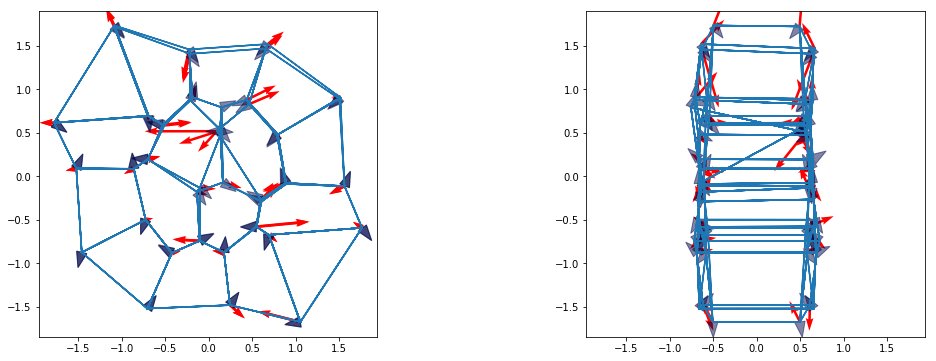

In [45]:
fig, (ax, bx) = plt.subplots(1, 2, sharex=True)
speed0 = solver.ode_func(0, eptm.vert_df[eptm.coords].values.ravel()).reshape((-1, 3))

fig, ax = sheet_view(eptm, mode="quick", coords=list('xy'), ax=ax)
fig, ax = plot_forces(eptm, geom, model, list('xy'), scaling=0.10, ax=ax)
quivers = ax.quiver(
    eptm.vert_df.x.values,
    eptm.vert_df.y.values,
    speed0[:, 0],
    speed0[:, 1], color='red'
)
fig, ax = sheet_view(eptm, mode="quick", coords=list('zy'), ax=bx)
fig, bx = plot_forces(eptm, geom, model, list('zy'), scaling=0.10, ax=bx)
quivers = bx.quiver(
    eptm.vert_df.z.values,
    eptm.vert_df.y.values,
    speed0[:, 2],
    speed0[:, 1], color='red'
)


fig.set_size_inches(18, 6)



In [ ]:
1.1**10

In [119]:

ipv.clear()

eptm.face_df['visible'] = True
eptm.get_opposite_faces()
outer = eptm.face_df[eptm.face_df["opposite"]==-1].index
eptm.face_df.loc[outer, "visible"] = False

fig, mesh = sheet_view(eptm, mode="3D", face={"visible": True, "color":eptm.face_df['area']})
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [ ]:
1.1 ** 100

In [98]:
history = History(eptm)

